In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3 import TD3  # Change 1: Import TD3
from stable_baselines3.common.noise import NormalActionNoise # Change 2: Import Noise
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, CallbackList, EvalCallback
from asv_glider_bearing_dist_env import AsvGliderBearingEnv

# --- 1. Define the Rollout Callback ---
class TrajectoryPlotCallback(BaseCallback):
    def __init__(self, eval_env, render_freq=10000, log_dir="./rollouts/"):
        super().__init__()
        self.eval_env = eval_env
        self.render_freq = render_freq
        self.log_dir = log_dir
        os.makedirs(self.log_dir, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.render_freq == 0:
            obs, _ = self.eval_env.reset(seed=123) 
            asv_history, glider_history = [], []
            done = False
            
            lstm_states = None
            episode_starts = np.ones((1,), dtype=bool)

            while not done:
                # TD3 uses the same predict interface as SAC
                action, _ = self.model.predict(
                    obs, 
                    state=lstm_states, 
                    episode_start=episode_starts, 
                    deterministic=True
                )
                obs, reward, terminated, truncated, _ = self.eval_env.step(action)
                
                asv_history.append(self.eval_env.unwrapped.asv_pos.copy())
                glider_history.append(self.eval_env.unwrapped.glider_pos.copy())
                
                done = terminated or truncated

            asv_history, glider_history = np.array(asv_history), np.array(glider_history)
            
            plt.figure(figsize=(6, 6))
            plt.plot(glider_history[:, 0], glider_history[:, 1], 'g--', label="Glider Path", alpha=0.6)
            plt.plot(asv_history[:, 0], asv_history[:, 1], 'b-', label="ASV Path (TD3)", linewidth=2)
            plt.title(f"TD3 Rollout at Step {self.n_calls}")
            plt.xlabel("X Position (m)")
            plt.ylabel("Y Position (m)")
            plt.legend()
            plt.grid(True)
            
            save_path = os.path.join(self.log_dir, f"rollout_{self.n_calls}.png")
            plt.savefig(save_path)
            plt.close()
            print(f">>> Saved TD3 rollout to {save_path}")
        return True

# --- 2. Setup Directories and Environments ---
algo_name = "td3" 
base_path = f"./experiments/{algo_name}/"
os.makedirs(base_path, exist_ok=True)

env = AsvGliderBearingEnv()
env = Monitor(env, os.path.join(base_path, "training_logs"))

eval_env = AsvGliderBearingEnv()
eval_env = Monitor(eval_env, os.path.join(base_path, "eval_logs"))

# --- 3. Initialize TD3 Model ---
# TD3 requires explicit action noise for exploration
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

model = TD3(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=7e-5, 
    gamma=0.99,
    buffer_size=1_000_000,
    learning_starts=10_000,
    batch_size=256,
    tau=0.005,
    train_freq=1,
    gradient_steps=1,
    action_noise=action_noise,   # Exploration noise
    policy_delay=2,              # Delayed policy updates (core TD3 feature)
    target_policy_noise=0.2,     # Target policy smoothing
    device="cuda",
)

# --- 4. Callbacks ---
eval_callback = EvalCallback(
    eval_env, 
    best_model_save_path=os.path.join(base_path, "best_model"),
    log_path=os.path.join(base_path, "eval_results"), 
    eval_freq=5000,
    deterministic=True,
    render=False
)

plot_callback = TrajectoryPlotCallback(
    eval_env, 
    render_freq=10000, 
    log_dir=os.path.join(base_path, "rollouts")
)

callbacks = CallbackList([eval_callback, plot_callback])

# --- 5. Train ---
try:
    print(f"Starting training for {algo_name}...")
    model.learn(
        total_timesteps=100_000, 
        callback=callbacks,
        progress_bar=True
    )
except KeyboardInterrupt:
    print("\nTraining interrupted.")
finally:
    env.close()
    eval_env.close()
    model.save(os.path.join(base_path, f"{algo_name}_final_model"))
    print("Environment closed and TD3 model saved.")

Output()

Using cuda device
Wrapping the env in a DummyVecEnv.
Starting training for td3...


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -433     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 5197     |
|    time_elapsed    | 0        |
|    total_timesteps | 4000     |
---------------------------------


Eval num_timesteps=5000, episode_reward=-711.92 +/- 560.27

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -712     |
| time/              |          |
|    total_timesteps | 5000     |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -393     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 2485     |
|    time_elapsed    | 3        |
|    total_timesteps | 8000     |
---------------------------------


Eval num_timesteps=10000, episode_reward=-807.08 +/- 643.59

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -807     |
| time/              |          |
|    total_timesteps | 10000    |
---------------------------------


>>> Saved TD3 rollout to ./experiments/td3/rollouts/rollout_10000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -649     |
| time/              |          |
|    episodes        | 12       |
|    fps             | 1039     |
|    time_elapsed    | 11       |
|    total_timesteps | 12000    |
| train/             |          |
|    actor_loss      | -8.61    |
|    critic_loss     | 5.14     |
|    learning_rate   | 7e-05    |
|    n_updates       | 1999     |
---------------------------------


Eval num_timesteps=15000, episode_reward=-2000.76 +/- 2005.98

Episode length: 988.20 +/- 23.60

---------------------------------
| eval/              |          |
|    mean_ep_length  | 988      |
|    mean_reward     | -2e+03   |
| time/              |          |
|    total_timesteps | 15000    |
| train/             |          |
|    actor_loss      | -15.3    |
|    critic_loss     | 3.15     |
|    learning_rate   | 7e-05    |
|    n_updates       | 4999     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -502     |
| time/              |          |
|    episodes        | 16       |
|    fps             | 630      |
|    time_elapsed    | 25       |
|    total_timesteps | 16000    |
| train/             |          |
|    actor_loss      | -20.5    |
|    critic_loss     | 27.6     |
|    learning_rate   | 7e-05    |
|    n_updates       | 5999     |
---------------------------------


Eval num_timesteps=20000, episode_reward=2509.94 +/- 255.81

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.51e+03 |
| time/              |          |
|    total_timesteps | 20000    |
| train/             |          |
|    actor_loss      | -56.7    |
|    critic_loss     | 3.07     |
|    learning_rate   | 7e-05    |
|    n_updates       | 9999     |
---------------------------------


New best mean reward!

>>> Saved TD3 rollout to ./experiments/td3/rollouts/rollout_20000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 44       |
| time/              |          |
|    episodes        | 20       |
|    fps             | 502      |
|    time_elapsed    | 39       |
|    total_timesteps | 20000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 468      |
| time/              |          |
|    episodes        | 24       |
|    fps             | 457      |
|    time_elapsed    | 52       |
|    total_timesteps | 24000    |
| train/             |          |
|    actor_loss      | -81.5    |
|    critic_loss     | 3.57     |
|    learning_rate   | 7e-05    |
|    n_updates       | 13999    |
---------------------------------


Eval num_timesteps=25000, episode_reward=2391.65 +/- 92.21

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.39e+03 |
| time/              |          |
|    total_timesteps | 25000    |
| train/             |          |
|    actor_loss      | -87.4    |
|    critic_loss     | 3.49     |
|    learning_rate   | 7e-05    |
|    n_updates       | 14999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 772      |
| time/              |          |
|    episodes        | 28       |
|    fps             | 418      |
|    time_elapsed    | 66       |
|    total_timesteps | 28000    |
| train/             |          |
|    actor_loss      | -103     |
|    critic_loss     | 4.8      |
|    learning_rate   | 7e-05    |
|    n_updates       | 17999    |
---------------------------------


Eval num_timesteps=30000, episode_reward=2466.02 +/- 80.25

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.47e+03 |
| time/              |          |
|    total_timesteps | 30000    |
| train/             |          |
|    actor_loss      | -112     |
|    critic_loss     | 3.96     |
|    learning_rate   | 7e-05    |
|    n_updates       | 19999    |
---------------------------------


>>> Saved TD3 rollout to ./experiments/td3/rollouts/rollout_30000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 938      |
| time/              |          |
|    episodes        | 32       |
|    fps             | 390      |
|    time_elapsed    | 81       |
|    total_timesteps | 32000    |
| train/             |          |
|    actor_loss      | -122     |
|    critic_loss     | 4.73     |
|    learning_rate   | 7e-05    |
|    n_updates       | 21999    |
---------------------------------


Eval num_timesteps=35000, episode_reward=2530.24 +/- 86.61

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.53e+03 |
| time/              |          |
|    total_timesteps | 35000    |
| train/             |          |
|    actor_loss      | -133     |
|    critic_loss     | 4.9      |
|    learning_rate   | 7e-05    |
|    n_updates       | 24999    |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.09e+03 |
| time/              |          |
|    episodes        | 36       |
|    fps             | 372      |
|    time_elapsed    | 96       |
|    total_timesteps | 36000    |
| train/             |          |
|    actor_loss      | -137     |
|    critic_loss     | 5.38     |
|    learning_rate   | 7e-05    |
|    n_updates       | 25999    |
---------------------------------


Eval num_timesteps=40000, episode_reward=2470.71 +/- 201.01

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.47e+03 |
| time/              |          |
|    total_timesteps | 40000    |
| train/             |          |
|    actor_loss      | -151     |
|    critic_loss     | 6.42     |
|    learning_rate   | 7e-05    |
|    n_updates       | 29999    |
---------------------------------


>>> Saved TD3 rollout to ./experiments/td3/rollouts/rollout_40000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.23e+03 |
| time/              |          |
|    episodes        | 40       |
|    fps             | 357      |
|    time_elapsed    | 111      |
|    total_timesteps | 40000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.34e+03 |
| time/              |          |
|    episodes        | 44       |
|    fps             | 350      |
|    time_elapsed    | 125      |
|    total_timesteps | 44000    |
| train/             |          |
|    actor_loss      | -165     |
|    critic_loss     | 6.5      |
|    learning_rate   | 7e-05    |
|    n_updates       | 33999    |
---------------------------------


Eval num_timesteps=45000, episode_reward=2523.54 +/- 260.00

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.52e+03 |
| time/              |          |
|    total_timesteps | 45000    |
| train/             |          |
|    actor_loss      | -167     |
|    critic_loss     | 5.78     |
|    learning_rate   | 7e-05    |
|    n_updates       | 34999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.43e+03 |
| time/              |          |
|    episodes        | 48       |
|    fps             | 341      |
|    time_elapsed    | 140      |
|    total_timesteps | 48000    |
| train/             |          |
|    actor_loss      | -176     |
|    critic_loss     | 5.11     |
|    learning_rate   | 7e-05    |
|    n_updates       | 37999    |
---------------------------------


Eval num_timesteps=50000, episode_reward=2503.97 +/- 122.69

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.5e+03  |
| time/              |          |
|    total_timesteps | 50000    |
| train/             |          |
|    actor_loss      | -181     |
|    critic_loss     | 4.38     |
|    learning_rate   | 7e-05    |
|    n_updates       | 39999    |
---------------------------------


>>> Saved TD3 rollout to ./experiments/td3/rollouts/rollout_50000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.5e+03  |
| time/              |          |
|    episodes        | 52       |
|    fps             | 332      |
|    time_elapsed    | 156      |
|    total_timesteps | 52000    |
| train/             |          |
|    actor_loss      | -188     |
|    critic_loss     | 6.29     |
|    learning_rate   | 7e-05    |
|    n_updates       | 41999    |
---------------------------------


Eval num_timesteps=55000, episode_reward=2220.17 +/- 266.37

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.22e+03 |
| time/              |          |
|    total_timesteps | 55000    |
| train/             |          |
|    actor_loss      | -190     |
|    critic_loss     | 5.65     |
|    learning_rate   | 7e-05    |
|    n_updates       | 44999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.54e+03 |
| time/              |          |
|    episodes        | 56       |
|    fps             | 326      |
|    time_elapsed    | 171      |
|    total_timesteps | 56000    |
| train/             |          |
|    actor_loss      | -196     |
|    critic_loss     | 6        |
|    learning_rate   | 7e-05    |
|    n_updates       | 45999    |
---------------------------------


Eval num_timesteps=60000, episode_reward=1854.16 +/- 928.02

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 1.85e+03 |
| time/              |          |
|    total_timesteps | 60000    |
| train/             |          |
|    actor_loss      | -198     |
|    critic_loss     | 6.18     |
|    learning_rate   | 7e-05    |
|    n_updates       | 49999    |
---------------------------------


>>> Saved TD3 rollout to ./experiments/td3/rollouts/rollout_60000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.61e+03 |
| time/              |          |
|    episodes        | 60       |
|    fps             | 320      |
|    time_elapsed    | 187      |
|    total_timesteps | 60000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.65e+03 |
| time/              |          |
|    episodes        | 64       |
|    fps             | 319      |
|    time_elapsed    | 200      |
|    total_timesteps | 64000    |
| train/             |          |
|    actor_loss      | -197     |
|    critic_loss     | 8.11     |
|    learning_rate   | 7e-05    |
|    n_updates       | 53999    |
---------------------------------


Eval num_timesteps=65000, episode_reward=2482.59 +/- 249.45

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.48e+03 |
| time/              |          |
|    total_timesteps | 65000    |
| train/             |          |
|    actor_loss      | -200     |
|    critic_loss     | 7.9      |
|    learning_rate   | 7e-05    |
|    n_updates       | 54999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.69e+03 |
| time/              |          |
|    episodes        | 68       |
|    fps             | 316      |
|    time_elapsed    | 215      |
|    total_timesteps | 68000    |
| train/             |          |
|    actor_loss      | -205     |
|    critic_loss     | 8.93     |
|    learning_rate   | 7e-05    |
|    n_updates       | 57999    |
---------------------------------


Eval num_timesteps=70000, episode_reward=2199.27 +/- 493.04

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.2e+03  |
| time/              |          |
|    total_timesteps | 70000    |
| train/             |          |
|    actor_loss      | -208     |
|    critic_loss     | 6.16     |
|    learning_rate   | 7e-05    |
|    n_updates       | 59999    |
---------------------------------


>>> Saved TD3 rollout to ./experiments/td3/rollouts/rollout_70000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.73e+03 |
| time/              |          |
|    episodes        | 72       |
|    fps             | 312      |
|    time_elapsed    | 230      |
|    total_timesteps | 72000    |
| train/             |          |
|    actor_loss      | -210     |
|    critic_loss     | 5.49     |
|    learning_rate   | 7e-05    |
|    n_updates       | 61999    |
---------------------------------


Eval num_timesteps=75000, episode_reward=2092.87 +/- 411.96

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.09e+03 |
| time/              |          |
|    total_timesteps | 75000    |
| train/             |          |
|    actor_loss      | -214     |
|    critic_loss     | 6.23     |
|    learning_rate   | 7e-05    |
|    n_updates       | 64999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.77e+03 |
| time/              |          |
|    episodes        | 76       |
|    fps             | 309      |
|    time_elapsed    | 245      |
|    total_timesteps | 76000    |
| train/             |          |
|    actor_loss      | -211     |
|    critic_loss     | 6.49     |
|    learning_rate   | 7e-05    |
|    n_updates       | 65999    |
---------------------------------


Eval num_timesteps=80000, episode_reward=2308.07 +/- 483.39

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.31e+03 |
| time/              |          |
|    total_timesteps | 80000    |
| train/             |          |
|    actor_loss      | -208     |
|    critic_loss     | 7.87     |
|    learning_rate   | 7e-05    |
|    n_updates       | 69999    |
---------------------------------


>>> Saved TD3 rollout to ./experiments/td3/rollouts/rollout_80000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.8e+03  |
| time/              |          |
|    episodes        | 80       |
|    fps             | 306      |
|    time_elapsed    | 260      |
|    total_timesteps | 80000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.81e+03 |
| time/              |          |
|    episodes        | 84       |
|    fps             | 306      |
|    time_elapsed    | 274      |
|    total_timesteps | 84000    |
| train/             |          |
|    actor_loss      | -213     |
|    critic_loss     | 6.32     |
|    learning_rate   | 7e-05    |
|    n_updates       | 73999    |
---------------------------------


Eval num_timesteps=85000, episode_reward=2132.24 +/- 152.52

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.13e+03 |
| time/              |          |
|    total_timesteps | 85000    |
| train/             |          |
|    actor_loss      | -207     |
|    critic_loss     | 7.61     |
|    learning_rate   | 7e-05    |
|    n_updates       | 74999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.84e+03 |
| time/              |          |
|    episodes        | 88       |
|    fps             | 303      |
|    time_elapsed    | 289      |
|    total_timesteps | 88000    |
| train/             |          |
|    actor_loss      | -211     |
|    critic_loss     | 7.85     |
|    learning_rate   | 7e-05    |
|    n_updates       | 77999    |
---------------------------------


Eval num_timesteps=90000, episode_reward=2009.55 +/- 1105.60

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.01e+03 |
| time/              |          |
|    total_timesteps | 90000    |
| train/             |          |
|    actor_loss      | -213     |
|    critic_loss     | 8.71     |
|    learning_rate   | 7e-05    |
|    n_updates       | 79999    |
---------------------------------


>>> Saved TD3 rollout to ./experiments/td3/rollouts/rollout_90000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.86e+03 |
| time/              |          |
|    episodes        | 92       |
|    fps             | 300      |
|    time_elapsed    | 305      |
|    total_timesteps | 92000    |
| train/             |          |
|    actor_loss      | -211     |
|    critic_loss     | 5.9      |
|    learning_rate   | 7e-05    |
|    n_updates       | 81999    |
---------------------------------


Eval num_timesteps=95000, episode_reward=1843.92 +/- 755.88

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 1.84e+03 |
| time/              |          |
|    total_timesteps | 95000    |
| train/             |          |
|    actor_loss      | -209     |
|    critic_loss     | 8.62     |
|    learning_rate   | 7e-05    |
|    n_updates       | 84999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.88e+03 |
| time/              |          |
|    episodes        | 96       |
|    fps             | 299      |
|    time_elapsed    | 320      |
|    total_timesteps | 96000    |
| train/             |          |
|    actor_loss      | -217     |
|    critic_loss     | 5.94     |
|    learning_rate   | 7e-05    |
|    n_updates       | 85999    |
---------------------------------


Eval num_timesteps=100000, episode_reward=2345.80 +/- 296.07

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.35e+03 |
| time/              |          |
|    total_timesteps | 100000   |
| train/             |          |
|    actor_loss      | -211     |
|    critic_loss     | 6.11     |
|    learning_rate   | 7e-05    |
|    n_updates       | 89999    |
---------------------------------


>>> Saved TD3 rollout to ./experiments/td3/rollouts/rollout_100000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.86e+03 |
| time/              |          |
|    episodes        | 100      |
|    fps             | 297      |
|    time_elapsed    | 336      |
|    total_timesteps | 100000   |
---------------------------------


Environment closed and TD3 model saved.


In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# from stable_baselines3 import TD3  # Changed from SAC
# from stable_baselines3.common.noise import NormalActionNoise # Added for exploration
# from stable_baselines3.common.monitor import Monitor
# from stable_baselines3.common.callbacks import BaseCallback, CallbackList, EvalCallback
# from asv_glider_bearing_dist_env import AsvGliderBearingEnv

# # --- 1. Define the Rollout Callback (Updated naming for TD3) ---
# class TrajectoryPlotCallback(BaseCallback):
#     def __init__(self, eval_env, render_freq=10000, log_dir="./rollouts_td3/"):
#         super().__init__()
#         self.eval_env = eval_env
#         self.render_freq = render_freq
#         self.log_dir = log_dir
#         os.makedirs(self.log_dir, exist_ok=True)

#     def _on_step(self) -> bool:
#         if self.n_calls % self.render_freq == 0:
#             obs, _ = self.eval_env.reset()
#             asv_history, glider_history = [], []
#             done = False
            
#             while not done:
#                 action, _ = self.model.predict(obs, deterministic=True)
#                 obs, reward, terminated, truncated, _ = self.eval_env.step(action)
#                 asv_history.append(self.eval_env.unwrapped.asv_pos.copy())
#                 glider_history.append(self.eval_env.unwrapped.glider_pos.copy())
#                 done = terminated or truncated

#             asv_history, glider_history = np.array(asv_history), np.array(glider_history)

#             plt.figure(figsize=(6, 6))
#             plt.plot(glider_history[:, 0], glider_history[:, 1], 'g--', label="Glider Path", alpha=0.6)
#             plt.plot(asv_history[:, 0], asv_history[:, 1], 'b-', label="ASV Path (TD3)", linewidth=2)
#             plt.scatter(asv_history[0, 0], asv_history[0, 1], c='blue', label="ASV Start")
#             plt.scatter(glider_history[0, 0], glider_history[0, 1], c='green', label="Glider Start")
#             plt.title(f"TD3 Rollout at Step {self.n_calls}")
#             plt.legend()
#             plt.grid(True)
            
#             save_path = os.path.join(self.log_dir, f"rollout_{self.n_calls}.png")
#             plt.savefig(save_path)
#             plt.close()
#             print(f">>> Saved TD3 trajectory to {save_path}")
#         return True

# # --- 2. Setup Directories and Environments ---
# log_dir = "./td3_asv_logs/"
# os.makedirs(log_dir, exist_ok=True)

# env = AsvGliderBearingEnv()
# env = Monitor(env, log_dir)
# eval_env = AsvGliderBearingEnv()

# # --- 3. Initialize TD3 Model ---
# # TD3 needs action noise for exploration
# n_actions = env.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# model = TD3(
#     "MlpPolicy",
#     env,
#     verbose=1,
#     learning_rate=7e-5, 
#     gamma=0.99,
#     buffer_size=1_000_000,
#     learning_starts=10_000,
#     batch_size=256,
#     tau=0.005,
#     train_freq=1,
#     gradient_steps=1,
#     action_noise=action_noise, # Crucial for TD3
#     policy_delay=2,            # Standard TD3 parameter
#     device="cuda",
# )

# # --- 4. Setup Evaluation ---
# eval_env = Monitor(eval_env, "./logs_td3/eval/")

# eval_callback = EvalCallback(
#     eval_env, 
#     best_model_save_path="./logs_td3/best_model",
#     log_path="./logs_td3/results", 
#     eval_freq=5000,
#     deterministic=True, 
#     render=False
# )

# plot_callback = TrajectoryPlotCallback(eval_env, render_freq=10000)
# callbacks = CallbackList([eval_callback, plot_callback])

# # --- 5. Train ---
# try:
#     print("Starting TD3 training...")
#     model.learn(
#         total_timesteps=100_000, 
#         callback=callbacks,
#         progress_bar=True
#     )
# except KeyboardInterrupt:
#     print("\nTraining interrupted.")
# finally:
#     env.close()
#     eval_env.close()
#     model.save("td3_asv_bearing_dist_final")
#     print("Environment closed. TD3 model saved.")

2026-01-12 22:24:22.321354: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-12 22:24:22.329458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768253062.338734   91261 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768253062.341560   91261 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768253062.349248   91261 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using cuda device
Wrapping the env in a DummyVecEnv.


Output()

Starting TD3 training...


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -438     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 5244     |
|    time_elapsed    | 0        |
|    total_timesteps | 4000     |
---------------------------------


Eval num_timesteps=5000, episode_reward=-572.21 +/- 863.25

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | -572     |
| time/              |          |
|    total_timesteps | 5000     |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -520     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 2565     |
|    time_elapsed    | 3        |
|    total_timesteps | 8000     |
---------------------------------


Eval num_timesteps=10000, episode_reward=-1160.45 +/- 604.99

Episode length: 1000.00 +/- 0.00

----------------------------------
| eval/              |           |
|    mean_ep_length  | 1e+03     |
|    mean_reward     | -1.16e+03 |
| time/              |           |
|    total_timesteps | 10000     |
----------------------------------


>>> Saved TD3 trajectory to ./rollouts_td3/rollout_10000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -571     |
| time/              |          |
|    episodes        | 12       |
|    fps             | 1052     |
|    time_elapsed    | 11       |
|    total_timesteps | 12000    |
| train/             |          |
|    actor_loss      | -9.69    |
|    critic_loss     | 1.79     |
|    learning_rate   | 7e-05    |
|    n_updates       | 1999     |
---------------------------------


Eval num_timesteps=15000, episode_reward=1015.00 +/- 1891.68

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 1.01e+03 |
| time/              |          |
|    total_timesteps | 15000    |
| train/             |          |
|    actor_loss      | -26      |
|    critic_loss     | 7.11     |
|    learning_rate   | 7e-05    |
|    n_updates       | 4999     |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -46.9    |
| time/              |          |
|    episodes        | 16       |
|    fps             | 638      |
|    time_elapsed    | 25       |
|    total_timesteps | 16000    |
| train/             |          |
|    actor_loss      | -30.6    |
|    critic_loss     | 8.9      |
|    learning_rate   | 7e-05    |
|    n_updates       | 5999     |
---------------------------------


Eval num_timesteps=20000, episode_reward=344.70 +/- 1460.10

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 345      |
| time/              |          |
|    total_timesteps | 20000    |
| train/             |          |
|    actor_loss      | -48.6    |
|    critic_loss     | 23.9     |
|    learning_rate   | 7e-05    |
|    n_updates       | 9999     |
---------------------------------


>>> Saved TD3 trajectory to ./rollouts_td3/rollout_20000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 238      |
| time/              |          |
|    episodes        | 20       |
|    fps             | 511      |
|    time_elapsed    | 39       |
|    total_timesteps | 20000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 586      |
| time/              |          |
|    episodes        | 24       |
|    fps             | 469      |
|    time_elapsed    | 51       |
|    total_timesteps | 24000    |
| train/             |          |
|    actor_loss      | -76.1    |
|    critic_loss     | 6.68     |
|    learning_rate   | 7e-05    |
|    n_updates       | 13999    |
---------------------------------


Eval num_timesteps=25000, episode_reward=2257.79 +/- 234.51

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.26e+03 |
| time/              |          |
|    total_timesteps | 25000    |
| train/             |          |
|    actor_loss      | -82.9    |
|    critic_loss     | 3.46     |
|    learning_rate   | 7e-05    |
|    n_updates       | 14999    |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 843      |
| time/              |          |
|    episodes        | 28       |
|    fps             | 429      |
|    time_elapsed    | 65       |
|    total_timesteps | 28000    |
| train/             |          |
|    actor_loss      | -101     |
|    critic_loss     | 3.85     |
|    learning_rate   | 7e-05    |
|    n_updates       | 17999    |
---------------------------------


Eval num_timesteps=30000, episode_reward=2406.45 +/- 188.59

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.41e+03 |
| time/              |          |
|    total_timesteps | 30000    |
| train/             |          |
|    actor_loss      | -111     |
|    critic_loss     | 3.82     |
|    learning_rate   | 7e-05    |
|    n_updates       | 19999    |
---------------------------------


New best mean reward!

>>> Saved TD3 trajectory to ./rollouts_td3/rollout_30000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.06e+03 |
| time/              |          |
|    episodes        | 32       |
|    fps             | 401      |
|    time_elapsed    | 79       |
|    total_timesteps | 32000    |
| train/             |          |
|    actor_loss      | -121     |
|    critic_loss     | 4.98     |
|    learning_rate   | 7e-05    |
|    n_updates       | 21999    |
---------------------------------


Eval num_timesteps=35000, episode_reward=1690.83 +/- 1777.83

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 1.69e+03 |
| time/              |          |
|    total_timesteps | 35000    |
| train/             |          |
|    actor_loss      | -134     |
|    critic_loss     | 3.32     |
|    learning_rate   | 7e-05    |
|    n_updates       | 24999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.21e+03 |
| time/              |          |
|    episodes        | 36       |
|    fps             | 384      |
|    time_elapsed    | 93       |
|    total_timesteps | 36000    |
| train/             |          |
|    actor_loss      | -140     |
|    critic_loss     | 6.28     |
|    learning_rate   | 7e-05    |
|    n_updates       | 25999    |
---------------------------------


Eval num_timesteps=40000, episode_reward=2049.24 +/- 651.14

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.05e+03 |
| time/              |          |
|    total_timesteps | 40000    |
| train/             |          |
|    actor_loss      | -155     |
|    critic_loss     | 5.96     |
|    learning_rate   | 7e-05    |
|    n_updates       | 29999    |
---------------------------------


>>> Saved TD3 trajectory to ./rollouts_td3/rollout_40000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.3e+03  |
| time/              |          |
|    episodes        | 40       |
|    fps             | 369      |
|    time_elapsed    | 108      |
|    total_timesteps | 40000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.4e+03  |
| time/              |          |
|    episodes        | 44       |
|    fps             | 364      |
|    time_elapsed    | 120      |
|    total_timesteps | 44000    |
| train/             |          |
|    actor_loss      | -164     |
|    critic_loss     | 5.09     |
|    learning_rate   | 7e-05    |
|    n_updates       | 33999    |
---------------------------------


Eval num_timesteps=45000, episode_reward=2006.84 +/- 891.90

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.01e+03 |
| time/              |          |
|    total_timesteps | 45000    |
| train/             |          |
|    actor_loss      | -167     |
|    critic_loss     | 5.63     |
|    learning_rate   | 7e-05    |
|    n_updates       | 34999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.48e+03 |
| time/              |          |
|    episodes        | 48       |
|    fps             | 356      |
|    time_elapsed    | 134      |
|    total_timesteps | 48000    |
| train/             |          |
|    actor_loss      | -174     |
|    critic_loss     | 5.71     |
|    learning_rate   | 7e-05    |
|    n_updates       | 37999    |
---------------------------------


Eval num_timesteps=50000, episode_reward=2401.04 +/- 327.22

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.4e+03  |
| time/              |          |
|    total_timesteps | 50000    |
| train/             |          |
|    actor_loss      | -176     |
|    critic_loss     | 6.64     |
|    learning_rate   | 7e-05    |
|    n_updates       | 39999    |
---------------------------------


>>> Saved TD3 trajectory to ./rollouts_td3/rollout_50000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.52e+03 |
| time/              |          |
|    episodes        | 52       |
|    fps             | 347      |
|    time_elapsed    | 149      |
|    total_timesteps | 52000    |
| train/             |          |
|    actor_loss      | -179     |
|    critic_loss     | 16       |
|    learning_rate   | 7e-05    |
|    n_updates       | 41999    |
---------------------------------


Eval num_timesteps=55000, episode_reward=2387.21 +/- 192.02

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.39e+03 |
| time/              |          |
|    total_timesteps | 55000    |
| train/             |          |
|    actor_loss      | -182     |
|    critic_loss     | 4.88     |
|    learning_rate   | 7e-05    |
|    n_updates       | 44999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.59e+03 |
| time/              |          |
|    episodes        | 56       |
|    fps             | 341      |
|    time_elapsed    | 163      |
|    total_timesteps | 56000    |
| train/             |          |
|    actor_loss      | -187     |
|    critic_loss     | 5.74     |
|    learning_rate   | 7e-05    |
|    n_updates       | 45999    |
---------------------------------


Eval num_timesteps=60000, episode_reward=2394.16 +/- 516.70

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.39e+03 |
| time/              |          |
|    total_timesteps | 60000    |
| train/             |          |
|    actor_loss      | -193     |
|    critic_loss     | 5.59     |
|    learning_rate   | 7e-05    |
|    n_updates       | 49999    |
---------------------------------


>>> Saved TD3 trajectory to ./rollouts_td3/rollout_60000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.64e+03 |
| time/              |          |
|    episodes        | 60       |
|    fps             | 335      |
|    time_elapsed    | 178      |
|    total_timesteps | 60000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.66e+03 |
| time/              |          |
|    episodes        | 64       |
|    fps             | 334      |
|    time_elapsed    | 191      |
|    total_timesteps | 64000    |
| train/             |          |
|    actor_loss      | -197     |
|    critic_loss     | 5.14     |
|    learning_rate   | 7e-05    |
|    n_updates       | 53999    |
---------------------------------


Eval num_timesteps=65000, episode_reward=1889.07 +/- 462.01

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 1.89e+03 |
| time/              |          |
|    total_timesteps | 65000    |
| train/             |          |
|    actor_loss      | -203     |
|    critic_loss     | 5.87     |
|    learning_rate   | 7e-05    |
|    n_updates       | 54999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.69e+03 |
| time/              |          |
|    episodes        | 68       |
|    fps             | 330      |
|    time_elapsed    | 206      |
|    total_timesteps | 68000    |
| train/             |          |
|    actor_loss      | -197     |
|    critic_loss     | 5.82     |
|    learning_rate   | 7e-05    |
|    n_updates       | 57999    |
---------------------------------


Eval num_timesteps=70000, episode_reward=2477.25 +/- 146.80

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.48e+03 |
| time/              |          |
|    total_timesteps | 70000    |
| train/             |          |
|    actor_loss      | -203     |
|    critic_loss     | 10.1     |
|    learning_rate   | 7e-05    |
|    n_updates       | 59999    |
---------------------------------


New best mean reward!

>>> Saved TD3 trajectory to ./rollouts_td3/rollout_70000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.72e+03 |
| time/              |          |
|    episodes        | 72       |
|    fps             | 325      |
|    time_elapsed    | 221      |
|    total_timesteps | 72000    |
| train/             |          |
|    actor_loss      | -203     |
|    critic_loss     | 8.1      |
|    learning_rate   | 7e-05    |
|    n_updates       | 61999    |
---------------------------------


Eval num_timesteps=75000, episode_reward=2594.96 +/- 328.36

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.59e+03 |
| time/              |          |
|    total_timesteps | 75000    |
| train/             |          |
|    actor_loss      | -202     |
|    critic_loss     | 6.01     |
|    learning_rate   | 7e-05    |
|    n_updates       | 64999    |
---------------------------------


New best mean reward!

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.71e+03 |
| time/              |          |
|    episodes        | 76       |
|    fps             | 322      |
|    time_elapsed    | 235      |
|    total_timesteps | 76000    |
| train/             |          |
|    actor_loss      | -205     |
|    critic_loss     | 6.72     |
|    learning_rate   | 7e-05    |
|    n_updates       | 65999    |
---------------------------------


Eval num_timesteps=80000, episode_reward=2584.00 +/- 164.47

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.58e+03 |
| time/              |          |
|    total_timesteps | 80000    |
| train/             |          |
|    actor_loss      | -205     |
|    critic_loss     | 4.42     |
|    learning_rate   | 7e-05    |
|    n_updates       | 69999    |
---------------------------------


>>> Saved TD3 trajectory to ./rollouts_td3/rollout_80000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.74e+03 |
| time/              |          |
|    episodes        | 80       |
|    fps             | 319      |
|    time_elapsed    | 250      |
|    total_timesteps | 80000    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.78e+03 |
| time/              |          |
|    episodes        | 84       |
|    fps             | 319      |
|    time_elapsed    | 263      |
|    total_timesteps | 84000    |
| train/             |          |
|    actor_loss      | -210     |
|    critic_loss     | 6.3      |
|    learning_rate   | 7e-05    |
|    n_updates       | 73999    |
---------------------------------


Eval num_timesteps=85000, episode_reward=2000.88 +/- 746.33

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2e+03    |
| time/              |          |
|    total_timesteps | 85000    |
| train/             |          |
|    actor_loss      | -211     |
|    critic_loss     | 4.94     |
|    learning_rate   | 7e-05    |
|    n_updates       | 74999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.77e+03 |
| time/              |          |
|    episodes        | 88       |
|    fps             | 317      |
|    time_elapsed    | 277      |
|    total_timesteps | 88000    |
| train/             |          |
|    actor_loss      | -211     |
|    critic_loss     | 5.63     |
|    learning_rate   | 7e-05    |
|    n_updates       | 77999    |
---------------------------------


Eval num_timesteps=90000, episode_reward=2365.52 +/- 153.72

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.37e+03 |
| time/              |          |
|    total_timesteps | 90000    |
| train/             |          |
|    actor_loss      | -216     |
|    critic_loss     | 5.7      |
|    learning_rate   | 7e-05    |
|    n_updates       | 79999    |
---------------------------------


>>> Saved TD3 trajectory to ./rollouts_td3/rollout_90000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.81e+03 |
| time/              |          |
|    episodes        | 92       |
|    fps             | 314      |
|    time_elapsed    | 292      |
|    total_timesteps | 92000    |
| train/             |          |
|    actor_loss      | -213     |
|    critic_loss     | 5.14     |
|    learning_rate   | 7e-05    |
|    n_updates       | 81999    |
---------------------------------


Eval num_timesteps=95000, episode_reward=2492.53 +/- 127.41

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.49e+03 |
| time/              |          |
|    total_timesteps | 95000    |
| train/             |          |
|    actor_loss      | -211     |
|    critic_loss     | 4.68     |
|    learning_rate   | 7e-05    |
|    n_updates       | 84999    |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.84e+03 |
| time/              |          |
|    episodes        | 96       |
|    fps             | 312      |
|    time_elapsed    | 306      |
|    total_timesteps | 96000    |
| train/             |          |
|    actor_loss      | -214     |
|    critic_loss     | 4.83     |
|    learning_rate   | 7e-05    |
|    n_updates       | 85999    |
---------------------------------


Eval num_timesteps=100000, episode_reward=2264.83 +/- 528.94

Episode length: 1000.00 +/- 0.00

---------------------------------
| eval/              |          |
|    mean_ep_length  | 1e+03    |
|    mean_reward     | 2.26e+03 |
| time/              |          |
|    total_timesteps | 100000   |
| train/             |          |
|    actor_loss      | -213     |
|    critic_loss     | 6.23     |
|    learning_rate   | 7e-05    |
|    n_updates       | 89999    |
---------------------------------


>>> Saved TD3 trajectory to ./rollouts_td3/rollout_100000.png

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 1.87e+03 |
| time/              |          |
|    episodes        | 100      |
|    fps             | 310      |
|    time_elapsed    | 321      |
|    total_timesteps | 100000   |
---------------------------------


Environment closed. TD3 model saved.


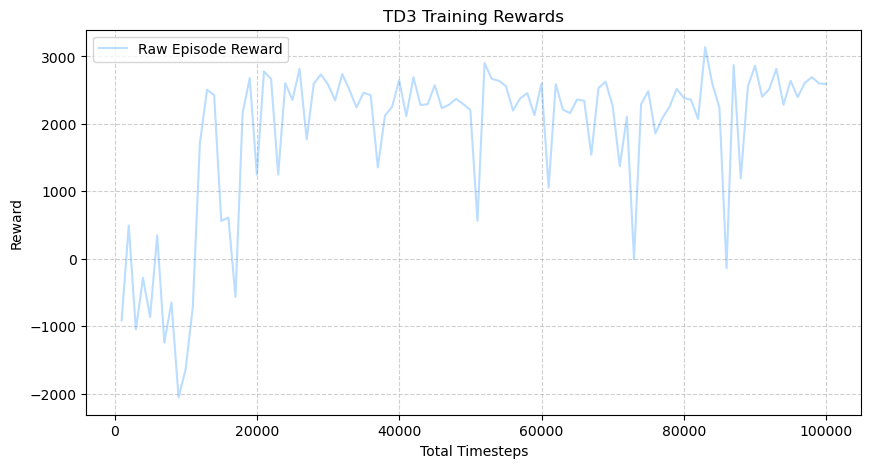

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3.common.results_plotter import load_results, ts2xy

def plot_learning_curve(log_folder, title="TD3 Training Rewards"):
    # Load the results from the monitor file
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    
    plt.figure(figsize=(10, 5))
    
    # Plot raw rewards in light blue
    plt.plot(x, y, alpha=0.3, color='dodgerblue', label="Raw Episode Reward")
    
    # # Calculate and plot smoothed rewards
    # if len(y) > 50:
    #     # Convert to numpy array with .values to avoid the ValueError
    #     y_smoothed = pd.Series(y).rolling(window=50).mean().values
    #     plt.plot(x, y_smoothed, color='blue', linewidth=2, label="Rolling Mean (50 ep)")
    
    plt.xlabel('Total Timesteps')
    plt.ylabel('Reward')
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Run the plotting function
plot_learning_curve("./td3_asv_logs/")

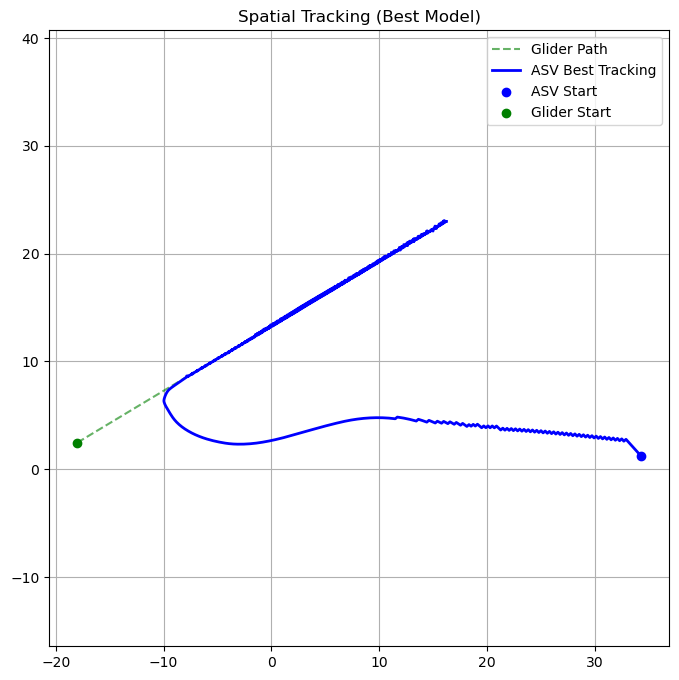

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
import os

# 1. Path to the best model
# Note: Adjust 'logs' to match the folder name you used in the EvalCallback
model_path = "./logs_td3/best_model/best_model.zip"

if not os.path.exists(model_path):
    print(f"Error: Could not find the best model at {model_path}")
else:
    # 2. Load the best model
    model = TD3.load(model_path)
    env = AsvGliderBearingEnv()
    obs, _ = env.reset()

    asv_path, glider_path, rewards = [], [], []
    done = False

    # 3. Run a test episode
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        
        asv_path.append(env.asv_pos.copy())
        glider_path.append(env.glider_pos.copy())
        rewards.append(reward)
        done = terminated or truncated

    asv_path, glider_path = np.array(asv_path), np.array(glider_path)

    # 4. Plot the Map
    plt.figure(figsize=(8, 8))
    plt.plot(glider_path[:, 0], glider_path[:, 1], 'g--', label="Glider Path", alpha=0.6)
    plt.plot(asv_path[:, 0], asv_path[:, 1], 'b-', label="ASV Best Tracking", linewidth=2)
    plt.scatter(asv_path[0,0], asv_path[0,1], c='blue', label="ASV Start")
    plt.scatter(glider_path[0,0], glider_path[0,1], c='green', label="Glider Start")
    plt.title("Spatial Tracking (Best Model)")
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()